In [2]:
import dsgp4

In [8]:
import torch

In [ ]:
# import matplotlib 

In [4]:
tles=dsgp4.tle.load(r'C:\Users\Public\Documents\job\tle-2025-06-22--2025-06-23.txt')

In [26]:
tles[50:]

[TLE(
 1 00124U 61015J   25173.22503852  .00000547  00000-0  21674-3 0  9994
 2 00124  66.5437 119.7245 0068230  15.6707 344.6482 14.35062192307266
 ),
 TLE(
 1 00125U 61015K   25172.81869955  .00000032  00000-0  64446-4 0  9992
 2 00125  66.8754 111.2402 0077645 323.9522  35.6343 14.07359384266543
 ),
 TLE(
 1 00125U 61015K   25173.24509078  .00000010  00000-0  51751-4 0  9998
 2 00125  66.8755 110.1734 0077662 323.6640  35.9188 14.07359467266606
 ),
 TLE(
 1 00126U 61015L   25172.82581101  .00001495  00000-0  45891-3 0  9994
 2 00126  66.7099 338.0250 0057913 170.3561 189.8671 14.43460828312564
 ),
 TLE(
 1 00126U 61015L   25173.44940234  .00001453  00000-0  44686-3 0  9994
 2 00126  66.7100 336.3585 0057856 169.8747 190.3539 14.43462613312658
 ),
 TLE(
 1   126U 61015L   25173.44940234  .00001453  00000-0  44686-3 0  9994
 2   126  66.7100 336.3585 0057856 169.8747 190.3539 14.43462613313075
 ),
 TLE(
 1 00127U 61015M   25172.77405484  .00001055  00000-0  30606-3 0  9998
 2 00127  6

In [9]:
my_tle = tles[0]

In [19]:
my_tle.satellite_catalog_number

5

In [10]:
#we always have to initialize the TLE before we can use it. If that does not, it can be directly initialized during propagation (with a small performance penalty):
dsgp4.initialize_tle(my_tle)

tensor([-7.5830e-07,  2.1211e-13,  0.0000e+00,  1.8418e-01,  5.4522e+00,
         5.9794e-01,  5.8388e-01,  4.7383e-02,  6.0646e+00])

In [11]:
#I propagate for 1 day:
tsinces = torch.linspace(0,24*60,10000)
state_teme=dsgp4.propagate(my_tle,tsinces)

In [18]:
state_teme[10000-1]

tensor([[ 1.0683e+03, -5.9878e+03, -3.7304e+03],
        [ 7.8055e+00,  8.1494e-01,  1.9659e+00]])

<Axes3D: xlabel='X [km]', ylabel='Y [km]', zlabel='Z [km]'>

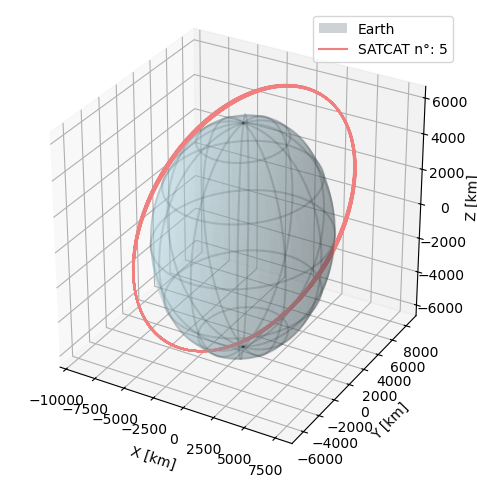

In [12]:
dsgp4.plot_orbit(state_teme,
                 color='lightcoral',
                 label=f'SATCAT n°: {my_tle.satellite_catalog_number}')

#tle file processing

filter: recurring satellites, anything whose perigee is not below 1000km altidtude  

In [38]:
from collections import defaultdict

In [40]:
groups = defaultdict(list)
for tle in tles:
    groups[tle.satellite_catalog_number].append(tle)

In [42]:
latest_tles = []
for satid, tlegroup in groups.items():
    # epoch_datetime() gives you Python datetime
    newest = max(tlegroup, key=lambda tle: tle.epoch_days)
    latest_tles.append(newest)

In [44]:
len(tles)

52967

In [45]:
len(latest_tles)

23731

In [46]:
import re

def extract_norad_ids(file_path):
    ids = []
    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if line.startswith('1 '):  # Line 1 of TLE
            match = re.match(r'1\s+(\d+)', line)
            if match:
                ids.append(int(match.group(1)))
    return ids

In [51]:
leo_ids = extract_norad_ids(r"C:\Users\Public\Documents\job\leo_3le.txt")

with open(r"C:\Users\Public\Documents\job\leo_ids.txt", "w") as f:
    for _id in leo_ids:
        f.write(f"{_id}\n")


In [52]:
import pandas as pd

In [53]:
df = pd.DataFrame(tles)

In [60]:
structured = [tle.__dict__ for tle in tles]

In [61]:
structured = [{
    "satellite_catalog_number": tle.satellite_catalog_number,
    "epoch_year": tle.epoch_year,
    "epoch_days": tle.epoch_days,
    "mean_motion": tle.mean_motion,
    "eccentricity": tle.eccentricity,
    "inclination": tle.inclination,
    "raan": tle.raan,
    "argument_of_perigee": tle.argument_of_perigee,
    "mean_anomaly": tle.mean_anomaly,
    "b_star": tle.b_star,
    
} for tle in tles]

In [62]:
df = pd.DataFrame(structured)

In [63]:
df.head()

,satellite_catalog_number,epoch_year,epoch_days,mean_motion,eccentricity,inclination,raan,argument_of_perigee,mean_anomaly,b_star
0,5,2025,172.535907,0.000790,0.184175,0.597938,6.064593,5.452229,0.583881,-7.583000e-07
1,5,2025,173.547997,0.000790,0.184171,0.597924,6.010083,5.531847,0.524601,-1.066900e-05
2,11,2025,172.912052,0.000865,0.144860,0.573690,0.140982,2.924249,3.430024,5.914600e-04
3,11,2025,173.583211,0.000865,0.144862,0.573697,0.096688,2.990859,3.342299,5.719200e-04
4,12,2025,172.737385,0.000835,0.164851,0.574245,0.959432,6.232141,0.036832,2.593400e-04


In [67]:
df_latest = df.sort_values('epoch_days').groupby('satellite_catalog_number', as_index=False).last()


In [68]:
df_latest

,satellite_catalog_number,epoch_year,epoch_days,mean_motion,eccentricity,inclination,raan,argument_of_perigee,mean_anomaly,b_star
0,5,2025,173.547997,0.000790,0.184171,0.597924,6.010083,5.531847,0.524601,-0.000011
1,11,2025,173.583211,0.000865,0.144862,0.573697,0.096688,2.990859,3.342299,0.000572
2,12,2025,173.085574,0.000835,0.164849,0.574241,0.938043,6.264289,0.014094,0.000262
3,16,2025,173.524451,0.000763,0.202305,0.597986,4.628821,0.728281,5.796460,-0.000063
4,20,2025,173.231396,0.000844,0.164300,0.582100,2.127748,4.978519,0.999833,0.000200
...,...,...,...,...,...,...,...,...,...,...
23726,270376,2025,173.538980,0.000954,0.006668,1.800747,4.627887,4.363089,1.909467,0.018820
23727,270413,2025,173.305646,0.001068,0.014851,1.548990,5.274982,0.130709,6.158382,0.000213
23728,270425,2025,173.298274,0.001064,0.013744,1.544341,5.102067,5.971319,0.305590,0.000594
23729,270429,2025,173.507959,0.001042,0.000703,1.533383,4.727793,5.217318,1.066724,0.001065


In [70]:
df_leos = df_latest[df_latest['satellite_catalog_number'].isin(leo_ids)]

In [71]:
df_leos

,satellite_catalog_number,epoch_year,epoch_days,mean_motion,eccentricity,inclination,raan,argument_of_perigee,mean_anomaly,b_star
1,11,2025,173.583211,0.000865,0.144862,0.573697,0.096688,2.990859,3.342299,0.000572
4,20,2025,173.231396,0.000844,0.164300,0.582100,2.127748,4.978519,0.999833,0.000200
5,22,2025,173.569623,0.001105,0.009175,0.877457,1.133652,2.181377,4.118586,0.000342
6,29,2025,173.511843,0.001075,0.002231,0.844373,5.114209,2.819735,3.466465,0.000082
7,45,2025,173.443893,0.001044,0.024300,1.164007,4.039969,1.062652,5.264499,0.000056
...,...,...,...,...,...,...,...,...,...,...
23522,64336,2025,173.583356,0.001147,0.000140,0.750500,2.764403,4.843233,0.142265,-0.006848
23523,64337,2025,173.583356,0.001147,0.000135,0.750504,2.764572,4.746004,0.167806,-0.006813
23524,64338,2025,173.583356,0.001147,0.000147,0.750500,2.764670,4.831646,0.045366,-0.006709
23525,64339,2025,173.583356,0.001147,0.000177,0.750514,2.764481,4.771023,0.178793,-0.006999


In [72]:
#set TLEs, The Near Equatorial Orbit (NEqO) Constellation: teleos 1, teleos 2 , ds-eo, ds-sar neu-sar(decayed)
neqo = [41169, 56310, 52935 , 57481 ]


In [75]:
df_leos[df_leos['satellite_catalog_number'].isin(neqo)] #only teleos2 and ds-eo is found

,satellite_catalog_number,epoch_year,epoch_days,mean_motion,eccentricity,inclination,raan,argument_of_perigee,mean_anomaly,b_star
14596,52935,2025,173.625498,0.001098,0.000302,0.174468,6.034912,2.111211,4.172868,0.000176
16923,56310,2025,173.639124,0.001088,0.000078,0.174350,5.273284,4.707633,1.575769,0.000318


In [94]:
df_neqo = df_leos[df_leos['satellite_catalog_number'].isin(neqo)]
df_sampled = df_leos[~df_leos['satellite_catalog_number'].isin(neqo)].sample(n=1000)
df_batch = pd.concat([df_neqo, df_sampled])


In [95]:
df_batch

,satellite_catalog_number,epoch_year,epoch_days,mean_motion,eccentricity,inclination,raan,argument_of_perigee,mean_anomaly,b_star
14596,52935,2025,173.625498,0.001098,0.000302,0.174468,6.034912,2.111211,4.172868,0.000176
16923,56310,2025,173.639124,0.001088,0.000078,0.174350,5.273284,4.707633,1.575769,0.000318
16839,56170,2025,173.571926,0.001003,0.000899,1.413762,1.106687,3.080009,3.205302,0.000142
5646,25368,2025,173.387655,0.000890,0.035643,1.441396,3.048396,2.944411,3.355087,-0.000060
2873,13845,2025,173.367420,0.001001,0.074462,1.104903,5.015341,2.257159,4.147340,0.000472
...,...,...,...,...,...,...,...,...,...,...
20592,60923,2025,173.092302,0.001113,0.000109,0.927833,0.950892,1.340444,4.944699,0.000022
18082,57904,2025,173.597760,0.001093,0.000141,0.750537,4.999396,4.597902,1.686473,0.000061
22305,62993,2025,173.586288,0.001142,0.000295,0.750507,2.258210,4.846987,1.437129,0.001388
12061,45685,2025,173.594112,0.001095,0.000128,0.925981,2.419887,1.481654,4.803514,0.000056


In [78]:
from datetime import datetime, timedelta
import numpy as np

In [99]:
def tle_epoch_to_datetime(row):
    year = int(row['epoch_year'])  # just use as is!
    return datetime(year, 1, 1) + timedelta(days=float(row['epoch_days']))

In [100]:
df_batch['epoch_datetime'] = df_batch.apply(tle_epoch_to_datetime, axis=1)

In [101]:
t_start = min(df_batch['epoch_datetime'])
t_end = t_start + timedelta(days=3)  

step = timedelta(minutes=1)
time_grid = [t_start + i * step for i in range(int((t_end - t_start) / step))]

In [103]:
time_grid[:10]

[Timestamp('2025-06-21 15:29:47.031936'),
 Timestamp('2025-06-21 15:30:47.031936'),
 Timestamp('2025-06-21 15:31:47.031936'),
 Timestamp('2025-06-21 15:32:47.031936'),
 Timestamp('2025-06-21 15:33:47.031936'),
 Timestamp('2025-06-21 15:34:47.031936'),
 Timestamp('2025-06-21 15:35:47.031936'),
 Timestamp('2025-06-21 15:36:47.031936'),
 Timestamp('2025-06-21 15:37:47.031936'),
 Timestamp('2025-06-21 15:38:47.031936')]

In [104]:
epochs = df_batch['epoch_datetime'].tolist()  # length N
tsince_matrix = torch.tensor([
    [(t - epoch).total_seconds() / 60 for epoch in epochs]
    for t in time_grid  # length T
])

In [105]:
tsince_matrix.shape

torch.Size([4320, 1002])

In [ ]:
#workaround because I deleted some uneccessary fields ealier which i shouldn't
if 'classification' not in df_batch.columns:
    df_batch['classification'] = 'U'

df_batch['international_designator'] = '00000A'
df_batch['mean_motion_first_derivative'] = 0.0
df_batch['mean_motion_second_derivative'] = 0.0
df_batch['revolution_number_at_epoch'] = 0
df_batch['ephemeris_type'] = 0
df_batch['element_number'] = 0

In [110]:
df_batch.columns

Index(['satellite_catalog_number', 'epoch_year', 'epoch_days', 'mean_motion',
       'eccentricity', 'inclination', 'raan', 'argument_of_perigee',
       'mean_anomaly', 'b_star', 'epoch_datetime', 'classification'],
      dtype='object')

In [117]:
tle_dicts = df_batch.to_dict(orient='records')
tles = [dsgp4.tle.TLE(d) for d in tle_dicts]
_, tle_batch = dsgp4.initialize_tle(tles)


In [118]:
tsince_flat = tsince_matrix.flatten()
tle_batch_repeated = tle_batch.repeat(len(time_grid), 1) 

AttributeError: 'super' object has no attribute '__getattr__'

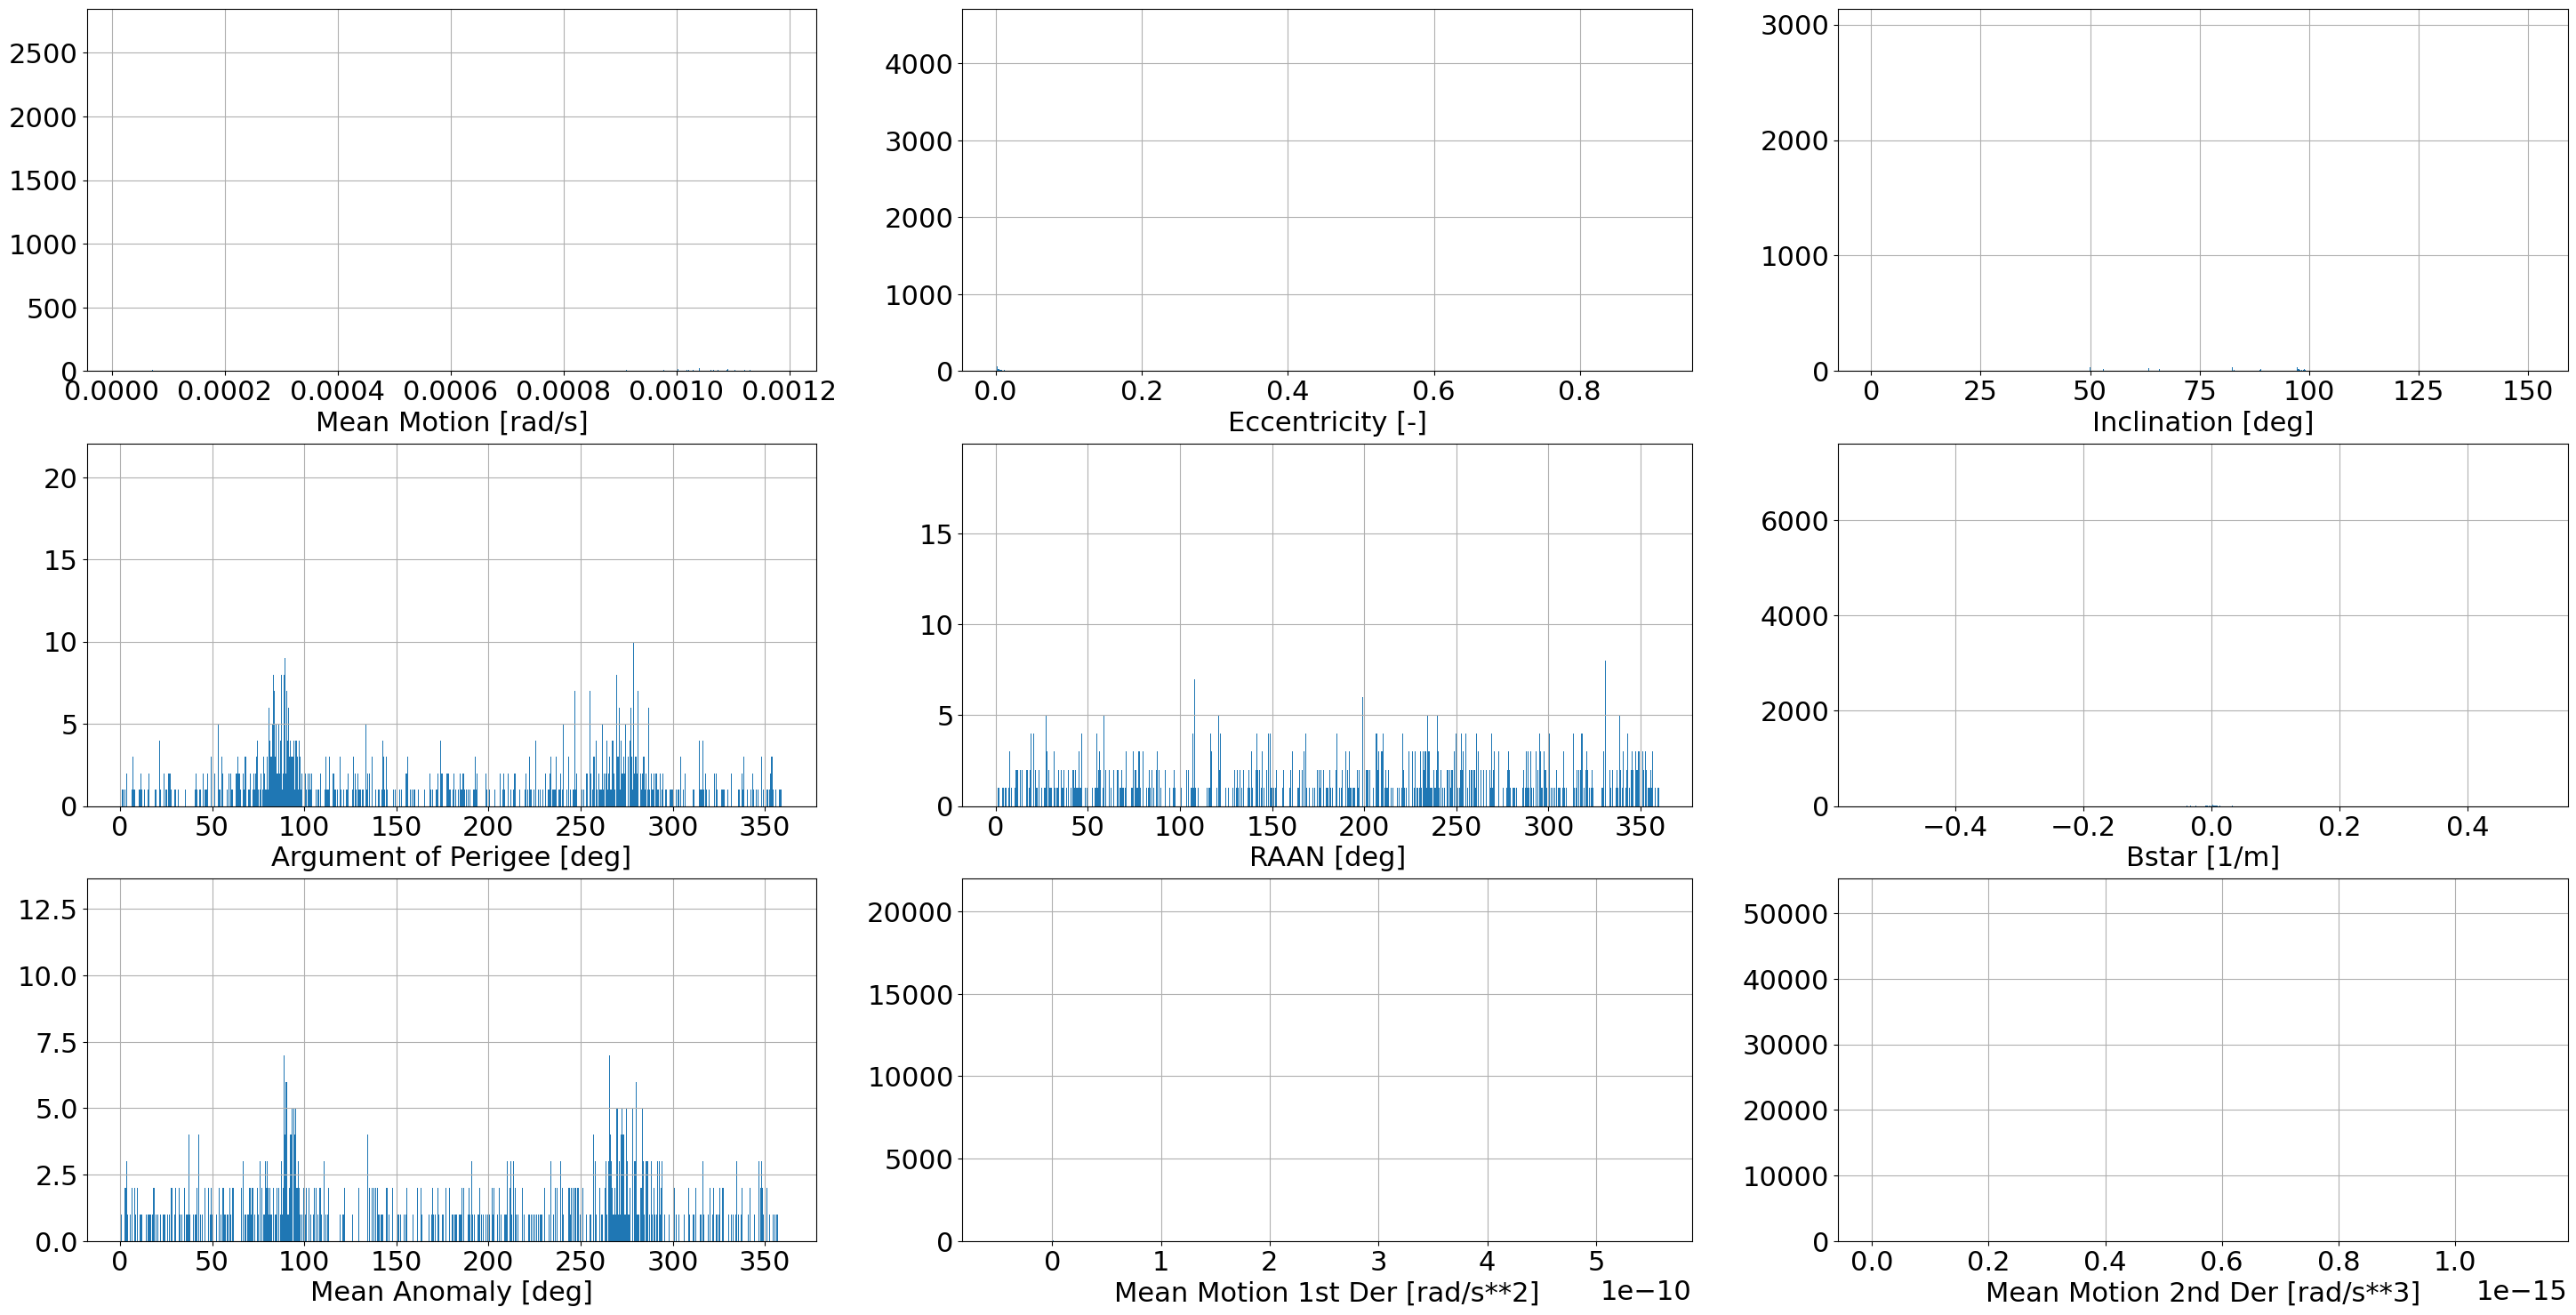

In [20]:
dsgp4.plot.plot_tles(tles)